### **Load Libraries**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, Reshape, multiply, add, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import DepthwiseConv2D, BatchNormalization, Activation, ZeroPadding2D
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, BatchNormalization,
                                     ReLU, GlobalAveragePooling2D, Reshape, Dense, multiply, Add)
from tensorflow.keras.models import Model

#### **Define Paths and Load Data**

In [ ]:
# Define paths
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")


                                            filepath      label
0  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
1  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
2  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
3  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
4  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA

The shape of The Train data is: (5233, 2)
The shape of The Test data is: (625, 2)


In [ ]:
# Create datasets
IMAGE_SIZE = (224,224)

print('\nTraining Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nValidation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nTesting Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Get class names
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

class_labels = ['NORMAL', 'PNEUMONIA']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))



Training Images:
Found 5232 files belonging to 2 classes.
Using 4709 files for training.

Validation Images:
Found 5232 files belonging to 2 classes.
Using 523 files for validation.

Testing Images:
Found 624 files belonging to 2 classes.


In [ ]:
# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "NORMAL")) if f.endswith('.jpeg')] +
               [f for f in os.listdir(os.path.join(path, "PNEUMONIA")) if f.endswith('.jpeg')])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

# Get class weights
allTrainFiles = [os.path.join(TRAIN_PATH, "NORMAL", f) for f in os.listdir(os.path.join(TRAIN_PATH, "NORMAL"))] + \
                [os.path.join(TRAIN_PATH, "PNEUMONIA", f) for f in os.listdir(os.path.join(TRAIN_PATH, "PNEUMONIA"))]

trainLabels = [0 if "NORMAL" in p else 1 for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = {i: classTotals.max() / classTotals[i] for i in range(len(classTotals))}

# Data generators
BATCH_SIZE = 16
INIT_LR = 1e-4
EPOCHS = 20

trainAug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

validationGen = valAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 5232 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### **Build model with SE Blocks**

In [ ]:
# Implement Squeeze and Excitation block
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

# Build SE-MobileNetV2 model (simplified SE integration)
def se_mobilenet_v2(input_shape=(224, 224, 3), alpha=1.0, include_top=True, weights='imagenet', classes=1000, ratio=16):
    base_model = MobileNetV2(input_shape=input_shape, alpha=alpha, include_top=False, weights=weights)

    x = base_model.output

    # Add SE blocks after layers with sufficient channels
    se_added = False
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
             if layer.output.shape[-1] is not None and layer.output.shape[-1] > ratio:
                x = squeeze_excite_block(layer.output, ratio=ratio)
                se_added = True

    if not se_added:
        # Add SE block after base model output if no suitable layers were found
        if x.shape[-1] is not None and x.shape[-1] > ratio:
          x = squeeze_excite_block(x, ratio=ratio)
        else:
            print("Not enough channels to add SE block.")


    if include_top:
        # Global pooling and classification
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(classes, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=x)

    # Freeze initial layers of the base model (optional)
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Model architecture
CLASSES = ["normal","pneumonia"]
model = se_mobilenet_v2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', ratio=16)

headModel = model.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(256, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation='softmax')(headModel)

model = Model(inputs=model.input, outputs=headModel)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,786,114 (10.63 MB)

 Trainable params: 533,250 (2.03 MB)

 Non-trainable params: 2,252,864 (8.59 MB)

#### **Compile Model & Train**

In [ ]:
# Compile model
print("Compiling model")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Callbacks
os.makedirs("/content/drive/MyDrive/chest_xray/New Models", exist_ok=True)
MCName = os.path.sep.join(["/content/drive/MyDrive/chest_xray", "SE_Mobilenetv2_weights-{epoch:03d}-{val_loss:.4f}.keras"])
checkpoint = ModelCheckpoint(
    MCName,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)
callbacks = [checkpoint]

# Train model
print("Model Fitting")
start_time = time.time()

history = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validationGen,
    validation_steps=totalTrain // (10 * BATCH_SIZE),
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.2f} minutes")

Compiling model
Model Fitting
Epoch 1/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8908 - loss: 0.4532

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.07777, saving model to /content/drive/MyDrive/chest_xray/SE_Mobilenetv2_weights-001-0.0778.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1967s 6s/step - accuracy: 0.8909 - loss: 0.4529 - val_accuracy: 0.9805 - val_loss: 0.0778
Epoch 2/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.9224 - loss: 0.2763
Epoch 2: val_loss improved from 0.07777 to 0.04021, saving model to /content/drive/MyDrive/chest_xray/SE_Mobilenetv2_weights-002-0.0402.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.9224 - loss: 0.2762 - val_accuracy: 0.9902 - val_loss: 0.0402
Epoch 3/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.9363 - loss: 0.2310
Epoch 3: val_loss did not improve from 0.04021
327/327 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9363 - loss: 0.2310 - val_accuracy: 0.9863 - val_loss: 0.0509
Epoch 4/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9379 - loss: 0.2381
Epoch 4: val_loss did not improve from 0.04021
327/32

#### **Plotting Training Curves**

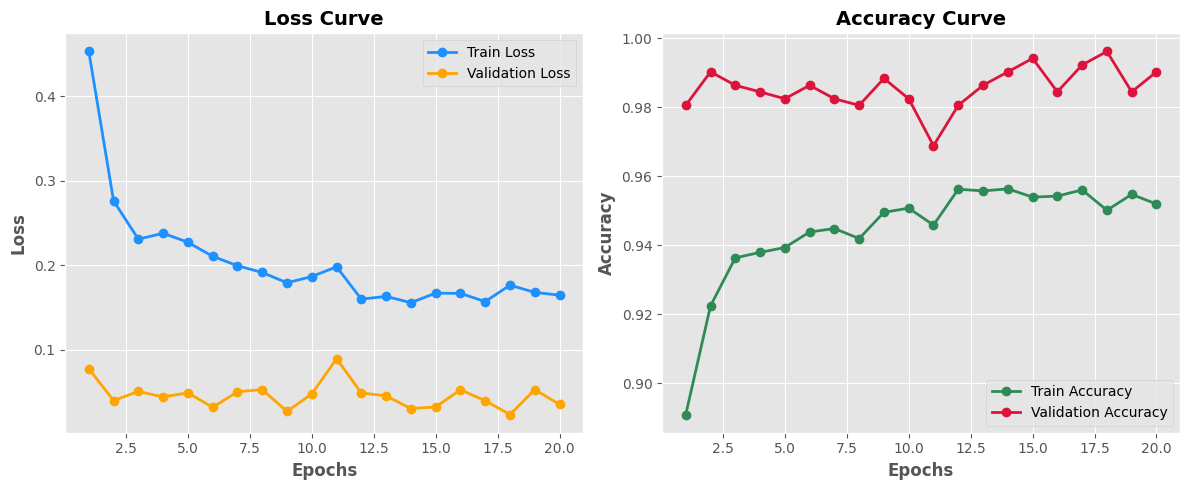

In [ ]:
# Plotting Training Curves (Manually: Training history out of memory)

# Epochs
epochs = list(range(1, 21))

# Training log data
train_loss = [
    0.4529, 0.2762, 0.2310, 0.2380, 0.2273,
    0.2107, 0.1996, 0.1916, 0.1794, 0.1868,
    0.1983, 0.1601, 0.1633, 0.1559, 0.1672,
    0.1669, 0.1572, 0.1766, 0.1681, 0.1648
]
val_loss = [
    0.0778, 0.0402, 0.0509, 0.0446, 0.0492,
    0.0323, 0.0505, 0.0532, 0.0273, 0.0480,
    0.0896, 0.0492, 0.0457, 0.0307, 0.0326,
    0.0529, 0.0400, 0.0236, 0.0530, 0.0357
]
train_acc = [
    0.8909, 0.9224, 0.9363, 0.9379, 0.9393,
    0.9438, 0.9448, 0.9419, 0.9495, 0.9507,
    0.9458, 0.9562, 0.9557, 0.9563, 0.9539,
    0.9542, 0.9560, 0.9501, 0.9547, 0.9519
]
val_acc = [
    0.9805, 0.9902, 0.9863, 0.9844, 0.9824,
    0.9863, 0.9824, 0.9805, 0.9883, 0.9824,
    0.9688, 0.9805, 0.9863, 0.9902, 0.9941,
    0.9844, 0.9922, 0.9961, 0.9844, 0.9902
]

# Plotting
plt.figure(figsize=(12, 5))

# ----------------------
# Loss Curve
# ----------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', label='Train Loss', color='dodgerblue', linewidth=2)
plt.plot(epochs, val_loss, 'o-', label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Loss Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)

# ----------------------
# Accuracy Curve
# ----------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', label='Train Accuracy', color='seagreen', linewidth=2)
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy', color='crimson', linewidth=2)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Accuracy Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Evaluation**


Evaluating model...
39/39 ━━━━━━━━━━━━━━━━━━━━ 227s 6s/step - accuracy: 0.9012 - loss: 0.2459
Test Accuracy: 93.91%
Test Loss: 0.1591
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 736ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9414    0.8932    0.9167       234
   PNEUMONIA     0.9378    0.9667    0.9520       390

    accuracy                         0.9391       624
   macro avg     0.9396    0.9299    0.9343       624
weighted avg     0.9392    0.9391    0.9388       624


Confusion Matrix:
[[209  25]
 [ 13 377]]
Accuracy: 0.9391
Sensitivity: 0.9667
Specificity: 0.8932


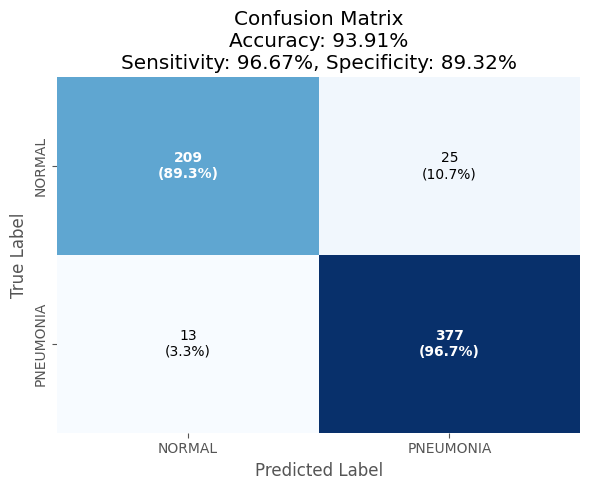

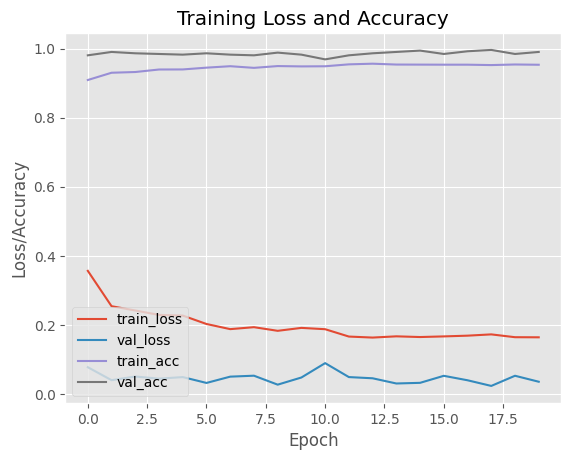

In [ ]:
# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen)
predTest = np.argmax(predIdxs, axis=1)

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys(), digits=4))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
# Calculate Sensitivity and Specificity
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=testGen.class_indices.keys(),
                yticklabels=testGen.class_indices.keys(),
                cbar=False)

# Add annotations with counts and class-wise percentages
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        is_correct = (i == j)
        text = f"{cm[i, j]}\n({percentage:.1f}%)"
        ax.text(j + 0.5, i + 0.5, text,
               ha='center', va='center',
               color='white' if is_correct else 'black',
               weight='bold' if is_correct else 'normal')

# Calculate metrics for title
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

plt.title(f"Confusion Matrix\nAccuracy: {acc:.2%}\nSensitivity: {sensitivity:.2%}, Specificity: {specificity:.2%}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot training history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

#### **Evaluation (From Saved Model)**

Loading best model from: /content/drive/MyDrive/chest_xray/SE_Mobilenetv2_weights-018-0.0236.keras

Evaluating model...
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 511ms/step - accuracy: 0.9161 - loss: 0.2075
Test Accuracy: 94.07%
Test Loss: 0.1527
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 474ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9301    0.9103    0.9201       234
   PNEUMONIA     0.9468    0.9590    0.9529       390

    accuracy                         0.9407       624
   macro avg     0.9385    0.9346    0.9365       624
weighted avg     0.9406    0.9407    0.9406       624


Confusion Matrix:
[[213  21]
 [ 16 374]]
Accuracy: 0.9407
Sensitivity: 0.9590
Specificity: 0.9103
AUC Score: 0.9851


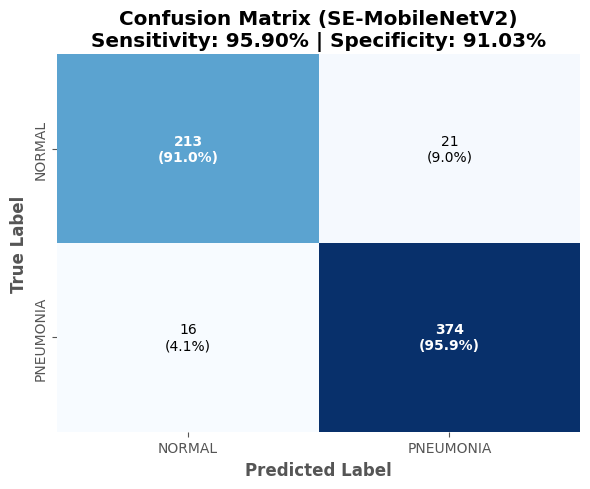

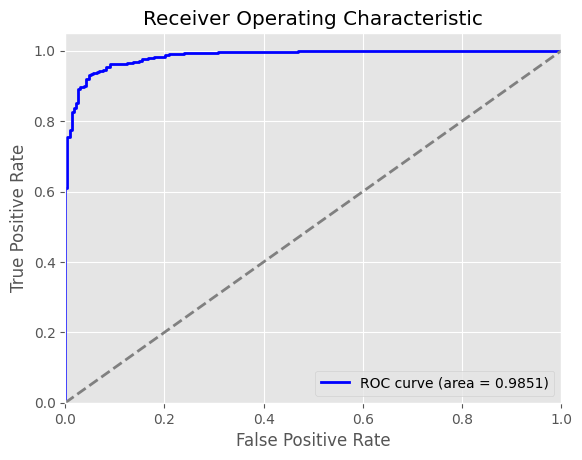

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Function to find the best saved model based on validation loss
def find_best_model(checkpoint_dir):
    best_loss = float('inf')
    best_model_path = None
    for filename in os.listdir(checkpoint_dir):
        if filename.startswith("SE") and filename.endswith(".keras"):
            parts = filename.split('-')
            try:
                # Assuming the format is SE_Mobilenetv2_weights-{epoch:03d}-{val_loss:.4f}.keras
                loss_str = parts[-1].split('.')[0] + '.' + parts[-1].split('.')[1]
                loss = float(loss_str)
                if loss < best_loss:
                    best_loss = loss
                    best_model_path = os.path.join(checkpoint_dir, filename)
            except (ValueError, IndexError):
                # Ignore files that don't match the expected naming convention
                continue
    return best_model_path

# Load the best saved model
checkpoint_dir = "/content/drive/MyDrive/chest_xray/"
best_model_path = find_best_model(checkpoint_dir)

if best_model_path:
    print(f"Loading best model from: {best_model_path}")
    model = load_model(best_model_path)

    # Evaluate model
    print("\nEvaluating model...")
    test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
    print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
    print("Test Loss: {:.4f}".format(test_results[0]))

    # Predictions and classification report
    predIdxs = model.predict(testGen)
    predTest = np.argmax(predIdxs, axis=1)

    print("\nClassification Report:")
    print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys(), digits=4))

    # Confusion matrix
    cm = confusion_matrix(testGen.classes, predTest)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    # Calculate Sensitivity and Specificity
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    print("\nConfusion Matrix:")
    print(cm)
    print("Accuracy: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

    # Calculate AUC score
    auc = roc_auc_score(testGen.classes, predIdxs[:, 1])
    print("AUC Score: {:.4f}".format(auc))

    # Plot confusion matrix with class-wise percentages
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=testGen.class_indices.keys(),
                    yticklabels=testGen.class_indices.keys(),
                    cbar=False)

    # Add annotations with counts and class-wise percentages
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
            is_correct = (i == j)
            text = f"{cm[i, j]}\n({percentage:.1f}%)"
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center',
                   color='white' if is_correct else 'black',
                   fontweight='bold' if is_correct else 'normal')

    # Calculate metrics for title
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    plt.title(f"Confusion Matrix (SE-MobileNetV2)\nSensitivity: {sensitivity:.2%} | Specificity: {specificity:.2%}", fontweight='bold')
    plt.xlabel("Predicted Label", fontweight='bold')
    plt.ylabel("True Label", fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(testGen.classes, predIdxs[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

else:
    print(f"No .keras model files found in {checkpoint_dir}")

#### **Model Size**

In [ ]:
import os

# Get the size of the best saved model
if best_model_path:
    model_size_bytes = os.path.getsize(best_model_path)
    model_size_megabytes = model_size_bytes / (1024 * 1024)
    print(f"Size of the saved model: {model_size_megabytes:.2f} MB")
else:
    print("No best model path found to calculate size.")

Size of the saved model: 15.27 MB
